In [1]:
%%time
%matplotlib inline
from new_import import *

CPU times: user 13.3 s, sys: 4.06 s, total: 17.4 s
Wall time: 10.9 s


In [2]:
%%time
# Cấu hình Daskgateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
# Khai báo 1 Datacube là dc
dc = datacube.Datacube()

client

Starting new cluster.
CPU times: user 747 ms, sys: 45.3 ms, total: 792 ms
Wall time: 3min 38s


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.d0762fb0432c4bde9b8458213d6b7ff1/status,


In [4]:
# Cấu hình truy cập dịch vụ S3
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

In [5]:
## cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2023-10-01')
longtitude_range = (105.5, 106.4)
latitude_range = (9.2, 10.0) 

In [46]:
## truy vấn ảnh vệ tinh sen2
data_sen2 = load_data(dc, date_range, longtitude_range, latitude_range)
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen2))

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


In [47]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_clean(data_sen2)
progress(result)

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 1.23 s, sys: 41.3 ms, total: 1.27 s
Wall time: 1.27 s


VBox()

In [48]:
# Tiến hành tính toán NDVI
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 151, y: 8874, x: 9902)>
dask.array<truediv, shape=(151, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648

In [50]:
%%time
## tính ndvi theo tháng
average_ndvi = ndvi.resample(time='1M').mean().persist()
progress(average_ndvi)

CPU times: user 739 ms, sys: 5.42 ms, total: 744 ms
Wall time: 743 ms


VBox()

In [53]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

In [4]:
datasets_sen1 = dc.find_datasets(
    product="sentinel1_grd_gamma0_20m",
    x=(105.5, 106.4),
    y=(9.2, 10.0),
    time=('2022-09-01', '2023-10-01')
)

In [9]:
data_sen1 = dc.load(
    product="sentinel1_grd_gamma0_20m",
    x=(105.5, 106.4),
    y=(9.2, 10.0),
    time=('2022-09-01', '2023-10-01'),
    measurements=["vv", "vh"],
    output_crs="EPSG:32648",
    resolution=(-10,10),
    dask_chunks={"x":2048, "y":2048},
    skip_broken_datasets=True,
    group_by='solar_day'
)

In [10]:
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen1))

In [11]:
data_sen1

<xarray.Dataset>
Dimensions:      (time: 33, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [12]:
data_sen1['vh']

<xarray.DataArray 'vh' (time: 33, y: 8874, x: 9902)>
dask.array<dc_load_vh, shape=(33, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [13]:
data_sen1['vv']

<xarray.DataArray 'vv' (time: 33, y: 8874, x: 9902)>
dask.array<dc_load_vv, shape=(33, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

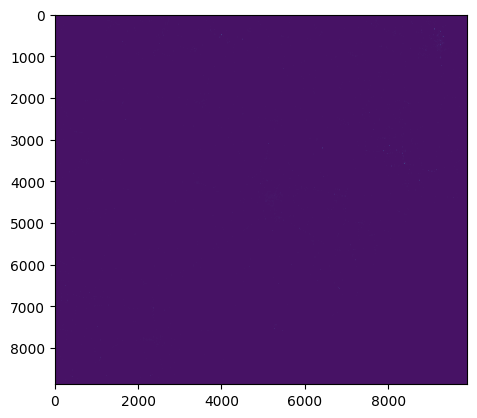

In [15]:
vv_data = data_sen1['vv'].isel(time=32)
plt.imshow(vv_data, cmap='viridis', vmin=-10, vmax=200)
plt.show()

In [107]:
print(data_sen1['vv'].min().values)

-160.52818


In [28]:
dsvv = data_sen1['vv'].resample(time='1M').mean().persist()
dsvv

<xarray.DataArray 'vv' (time: 13, y: 8874, x: 9902)>
dask.array<stack, shape=(13, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2022-09-30 2022-10-31 ... 2023-09-30
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

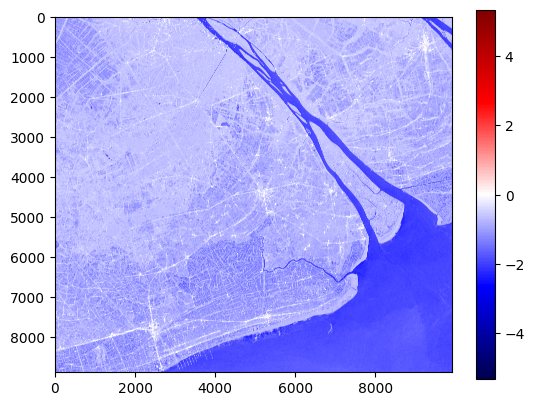

In [34]:
test = dsvv.isel(time=8)
log_test = np.sign(test) * np.log10(np.abs(test))

plt.imshow(log_test, cmap='seismic')
plt.colorbar()
plt.show()

In [19]:
dsvh = data_sen1['vh'].resample(time='1M').mean().persist()

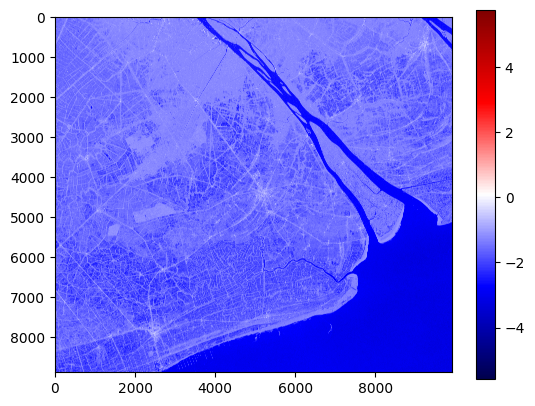

In [43]:
test = dsvh.isel(time=8)
log_test = np.sign(test) * np.log10(np.abs(test))

plt.imshow(log_test, cmap='seismic')
plt.colorbar()
plt.show()

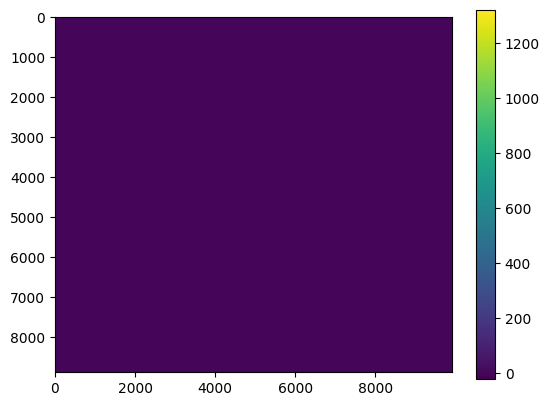

In [45]:
plt.imshow(dsvv.isel(time=8))
plt.colorbar()
plt.show()

In [14]:
from deafrica_tools.bandindices import dualpol_indices
new_data_sen1 = dualpol_indices(ds=data_sen1, index="RVI")

In [54]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# average_ndvi = average_ndvi[:, :7680, :8687]
mask = ~np.isnan(average_ndvi)
print(average_ndvi.shape)
print(dsvh.shape)
print(dsvv.shape)
print(mask.shape)
X_train = np.stack([dsvh.values[mask], dsvv.values[mask]], axis=1)
y_train = average_ndvi.values[mask]

(13, 8874, 9902)
(13, 8874, 9902)
(13, 8874, 9902)
(13, 8874, 9902)


In [106]:
num_true = mask.sum().values
print('f("số điểm train: {num_true}")')

f("số điểm train: {num_true}")


In [90]:
# Đếm số lượng điểm NaN
num_nan = np.sum(np.isnan(average_ndvi))
print(f"Số lượng điểm NaN: {num_nan.values}")

Số lượng điểm NaN: 0


In [87]:
average_ndvi

<xarray.DataArray 'NDVI' (time: 13, y: 8874, x: 9902)>
array([[[ 3.69087964e-01,  3.69087964e-01,  3.77295732e-01, ...,
          6.37900054e-01,  6.37840211e-01,  6.00014150e-01],
        [ 3.69712085e-01,  3.69712085e-01,  3.83763611e-01, ...,
          6.17527306e-01,  6.20078325e-01,  6.24745369e-01],
        [ 3.69712085e-01,  3.69712085e-01,  3.83763611e-01, ...,
          6.17195070e-01,  6.18910015e-01,  7.56559372e-01],
        ...,
        [ 1.72497004e-01,  4.58953112e-01,  2.66808212e-01, ...,
         -1.07296132e-01, -1.62162170e-01, -1.63636342e-01],
        [ 1.03626937e-01,  4.47405279e-01,  4.25044090e-01, ...,
         -1.84331805e-01, -1.42201796e-01, -1.60599545e-01],
        [-7.29386928e-04,  4.29869354e-01,  4.65222299e-01, ...,
         -1.11597389e-01, -1.44164741e-01, -1.15226299e-01]],

       [[ 3.45682532e-01,  3.45682532e-01,  3.45498413e-01, ...,
          3.98765475e-01,  4.02287304e-01,  4.02287304e-01],
        [ 3.46080899e-01,  3.46080899e-01,  3.45891744e-01, ...,
          4.11149591e-01,  4.14555103e-01,  4.14555103e-01],
        [ 3.46080899e-01,  3.46080899e-01,  3.45891744e-01, ...,
          4.11149591e-01,  4.14555103e-01,  4.14555103e-01],
...
         -1.16381489e-01, -2.45650217e-01, -2.56057948e-01],
        [ 1.34953871e-01,  6.61971867e-01,  6.72875404e-01, ...,
         -1.25083700e-01, -2.16893747e-01, -1.92835450e-01],
        [ 6.93548396e-02,  5.91334820e-01,  6.62259579e-01, ...,
         -1.28072619e-01, -1.65681735e-01, -1.16094612e-01]],

       [[ 3.93395871e-01,  3.93395871e-01,  3.94837111e-01, ...,
          8.56177986e-01,  8.37543666e-01,  7.80746520e-01],
        [ 3.93225193e-01,  3.93225193e-01,  3.93461317e-01, ...,
          8.29926431e-01,  8.19785774e-01,  8.17597389e-01],
        [ 3.93225193e-01,  3.93225193e-01,  3.93461317e-01, ...,
          8.32685590e-01,  8.06613624e-01,  8.07800591e-01],
        ...,
        [ 3.88286322e-01,  6.11940384e-01,  5.17369688e-01, ...,
         -3.31825316e-02, -2.29459926e-02, -4.85436544e-02],
        [ 3.34712833e-01,  6.66666687e-01,  6.42252684e-01, ...,
         -9.60827712e-03,  2.41758358e-02,  2.19135731e-03],
        [ 2.82383412e-01,  6.62507474e-01,  6.32222235e-01, ...,
         -2.05527749e-02,  9.85917915e-03, -2.33877134e-02]]],
      dtype=float32)
Coordinates:
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2022-09-30 2022-10-31 ... 2023-09-30

In [55]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [56]:
X_pred = np.stack([dsvh.values[~mask], dsvv.values[~mask]], axis=1)
average_ndvi.values[~mask] = model.predict(X_pred)

In [57]:
average_ndvi_filled = xr.DataArray(average_ndvi, dims=average_ndvi.dims)

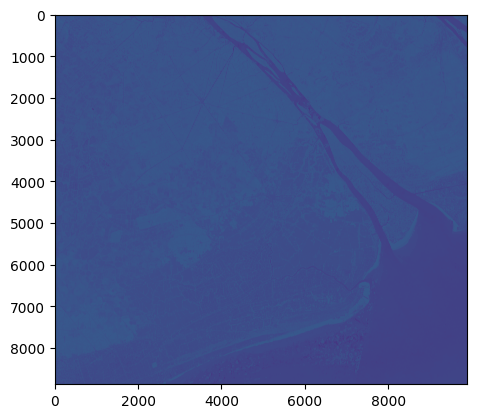

In [58]:
plt.imshow(average_ndvi_filled.isel(time=6))

In [59]:
train_path = "train/ST_training data_updated_1130points.shp"
train = load_train_data(train_path)

In [60]:
datasets = get_data_sen1_and_sen2(train, average_ndvi_filled, dsvh, dsvv)

In [61]:
# cấu hình nhãn dữ liệu
label_mapping = {
    "Lua tom": "0",
    "Lua": "1",
    "CHN": "2",
    "CLN": "3",
    "TS": "4",
    "Song": "5",
    "Dat xay dung": "6",
    "Rung": "7"
}

# chia tập dữ liệu train, val, test
X_train, X_val, X_test, y_train, y_val, y_test = split_train_data(train, label_mapping, datasets)

In [62]:
# Huấn luyện mô hình
grid_search = train_with_rf(X_train, X_val, y_train, y_val)

Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 15, 'classifier__n_estimators': 700}
Accuracy: 91.0 %


In [63]:
# kiểm tra độ chính xác với tập test
y_pred_test = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy for test data {round(test_accuracy, 2)*100} %")

Accuracy for test data 91.0 %


In [64]:
# Lưu mô hình huấn luyện
save_model("model_newVH-VV.joblib", grid_search)

Done!


In [71]:
# đóng client, cluster
client.close()
cluster.close()